In [1]:
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from itertools import cycle

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import time
from tqdm import tqdm

import chainladder as cl


In [2]:
prism = cl.load_sample("prism")
prism

,Triangle Summary
Valuation:,2017-12
Grain:,OMDM
Shape:,"(34244, 4, 120, 120)"
Index:,"[ClaimNo, Line, Type, ClaimLiability, Limit, Deductible]"
Columns:,"[reportedCount, closedPaidCount, Paid, Incurred]"


In [3]:
df = cl.load_sample("prism").to_frame(origin_as_datetime=True)
df_flat = df.reset_index()
df_flat


,ClaimNo,Line,Type,ClaimLiability,Limit,Deductible,origin,development,reportedCount,closedPaidCount,Paid,Incurred
0,1,Home,Dwelling,False,300000.0,20000,2008-01-01,34,1.0,NaN,NaN,NaN
1,2,Home,Dwelling,False,200000.0,20000,2008-01-01,35,1.0,NaN,NaN,NaN
2,3,Home,Dwelling,True,200000.0,20000,2008-01-01,26,1.0,1.0,115744.773700,115744.773700
3,4,Home,Dwelling,True,200000.0,20000,2008-01-01,23,1.0,1.0,63678.877130,63678.877130
4,5,Home,Dwelling,True,200000.0,20000,2008-01-01,28,1.0,1.0,112175.555900,112175.555900
...,...,...,...,...,...,...,...,...,...,...,...,...
34239,41461,Auto,PD,True,8000.0,1000,2017-10-01,3,1.0,1.0,7000.000000,7000.000000
34240,41582,Auto,PD,True,15000.0,1000,2017-11-01,1,1.0,1.0,4088.116947,4088.116947
34241,41596,Auto,PD,True,15000.0,1000,2017-11-01,2,1.0,1.0,10599.333280,10599.333280
34242,41845,Auto,PD,False,15000.0,1000,2017-11-01,2,1.0,NaN,NaN,NaN


In [4]:
prism_triangle_granular = cl.load_sample("prism")
prism_triangle_grouped = prism_triangle_granular.groupby(['Line', 'Type']).sum()


In [5]:
# Line: Home, Type: Dwelling, Data: Incurred
prism_triangle_Dwelling_Incurred = prism_triangle_grouped.loc[('Home', 'Dwelling'), 'Incurred']

df_triangle_Dwelling_Incurred = prism_triangle_Dwelling_Incurred.to_frame()
df_triangle_Dwelling_Incurred


,1,2,3,4,5,6,7,8,9,10,...,111,112,113,114,115,116,117,118,119,120
2008-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Line: Auto, Type: PD, Data: Incurred
prism_triangle_PD_Incurred = prism_triangle_grouped.loc[('Auto', 'PD'), 'Incurred']

df_triangle_PD_Incurred = prism_triangle_PD_Incurred.to_frame()
df_triangle_PD_Incurred


,1,2,3,4,5,6,7,8,9,10,...,111,112,113,114,115,116,117,118,119,120
2008-01-01,NaN,NaN,46915.015123,19898.778972,57215.983936,89783.258084,18301.827646,95054.432894,10332.363153,91772.229823,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-01,NaN,28749.365091,22109.176517,79032.630204,63454.689224,59993.109001,64682.696457,68501.669363,33694.528307,71670.163132,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-03-01,NaN,48805.786934,27949.453343,90412.574923,54556.680461,83507.369630,12591.483469,72035.009198,70352.890543,35222.888014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-04-01,NaN,30758.035988,17762.893769,70872.089511,30232.607725,39494.326674,66729.041632,122100.008971,20997.801217,38218.309668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-05-01,NaN,38672.002824,86973.993208,20482.742048,58399.893977,112014.627961,31353.769533,22456.706601,53777.576031,93303.380912,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-01,NaN,14000.000000,105952.492729,81991.210907,174870.150263,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,18589.176575,33316.659725,86056.984325,152143.727464,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-01,NaN,35037.196888,104444.385044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-01,4088.116947,10599.333280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
def ftn_chain_ladder(triangle_df: pd.DataFrame) -> pd.DataFrame:

    # Make a copy of the original DataFrame
    completed_triangle = triangle_df.copy()
    
    # --- Step 1: Calculate the development factors (phi_hat_k) ---    
    dev_factors = {}
    # Iterate through the development period columns, from the first to the second-to-last
    for i in range(len(completed_triangle.columns) - 1):
        prev_col = completed_triangle.columns[i]
        curr_col = completed_triangle.columns[i+1]
        
        # The formula is Sum(S_j,k) / Sum(S_j,k-1).
        # Sum of the current (later) development period, ignoring NaNs
        numerator = completed_triangle[curr_col].sum()
        
        # Sum of the previous (earlier) development period
        denominator = completed_triangle.loc[completed_triangle[curr_col].notna(), prev_col].sum()
        
        if denominator == 0:
            # Avoid division by zero; if the denominator is zero, assume no development.
            factor = 1.0
        else:
            factor = numerator / denominator
            
        # Store the factor for the period it develops.
        dev_factors[curr_col] = factor
        
    for period, factor in dev_factors.items():
        print(f"Factor for period {period}: {factor:.5f}")

    # --- Step 2: Fill the triangle using the factors (Chain Ladder Predictor) ---
    
    # Iterate through each row (origin period) of the triangle
    for i in range(len(completed_triangle)):
        # Get the current row by its integer position
        row = completed_triangle.iloc[i]
        
        # Find the column index of the last non-NaN value in the row (the latest diagonal)
        last_valid_index = row.last_valid_index()
        
        if last_valid_index is None or last_valid_index == completed_triangle.columns[-1]:
            # If the row is all NaN or already complete, skip to the next one
            continue
            
        # Get the latest known cumulative value for this origin period
        latest_value = row[last_valid_index]
        
        # Get the integer position of the last valid column
        last_col_pos = completed_triangle.columns.get_loc(last_valid_index)
        
        # Loop through the columns to the right of the latest known value
        for j in range(last_col_pos + 1, len(completed_triangle.columns)):
            target_col = completed_triangle.columns[j]
            
            # Get the appropriate development factor
            factor = dev_factors.get(target_col, 1.0) # Default to 1.0 if no factor exists
            
            # Apply the factor to project the next value
            projected_value = latest_value * factor
            
            # Update the DataFrame with the new, projected value
            completed_triangle.iloc[i, j] = projected_value
            
            # The newly projected value becomes the basis for the next projection
            latest_value = projected_value
            
    return completed_triangle


In [8]:
df_square_PD_Incurred_CL = ftn_chain_ladder(df_triangle_PD_Incurred)

df_square_PD_Incurred_CL

Factor for period 2: 4.22672
Factor for period 3: 1.83433
Factor for period 4: 1.42024
Factor for period 5: 0.96892
Factor for period 6: 1.07315
Factor for period 7: 0.96124
Factor for period 8: 1.01220
Factor for period 9: 0.99837
Factor for period 10: 0.87770
Factor for period 11: 0.94283
Factor for period 12: 1.10056
Factor for period 13: 0.82409
Factor for period 14: 0.98004
Factor for period 15: 0.85045
Factor for period 16: 1.00074
Factor for period 17: 0.96362
Factor for period 18: 0.90325
Factor for period 19: 0.89370
Factor for period 20: 0.90338
Factor for period 21: 1.01093
Factor for period 22: 0.93851
Factor for period 23: 0.91977
Factor for period 24: 0.96662
Factor for period 25: 0.93320
Factor for period 26: 1.05518
Factor for period 27: 0.88991
Factor for period 28: 1.13826
Factor for period 29: 0.85211
Factor for period 30: 1.25741
Factor for period 31: 1.13366
Factor for period 32: 0.85072
Factor for period 33: 1.38231
Factor for period 34: 1.15560
Factor for period 

,1,2,3,4,5,6,7,8,9,10,...,111,112,113,114,115,116,117,118,119,120
2008-01-01,NaN,NaN,46915.015123,19898.778972,57215.983936,89783.258084,18301.827646,95054.432894,10332.363153,91772.229823,...,6.646321e+06,6.646321e+06,6.646321e+06,6.646321e+06,6.646321e+06,6.646321e+06,6.646321e+06,6.646321e+06,6.646321e+06,6.646321e+06
2008-02-01,NaN,28749.365091,22109.176517,79032.630204,63454.689224,59993.109001,64682.696457,68501.669363,33694.528307,71670.163132,...,6.803310e+03,6.803310e+03,6.803310e+03,6.803310e+03,6.803310e+03,6.803310e+03,6.803310e+03,6.803310e+03,6.803310e+03,6.803310e+03
2008-03-01,NaN,48805.786934,27949.453343,90412.574923,54556.680461,83507.369630,12591.483469,72035.009198,70352.890543,35222.888014,...,2.005193e+03,2.005193e+03,2.005193e+03,2.005193e+03,2.005193e+03,2.005193e+03,2.005193e+03,2.005193e+03,2.005193e+03,2.005193e+03
2008-04-01,NaN,30758.035988,17762.893769,70872.089511,30232.607725,39494.326674,66729.041632,122100.008971,20997.801217,38218.309668,...,6.905159e+03,6.905159e+03,6.905159e+03,6.905159e+03,6.905159e+03,6.905159e+03,6.905159e+03,6.905159e+03,6.905159e+03,6.905159e+03
2008-05-01,NaN,38672.002824,86973.993208,20482.742048,58399.893977,112014.627961,31353.769533,22456.706601,53777.576031,93303.380912,...,1.900000e+04,1.900000e+04,1.900000e+04,1.900000e+04,1.900000e+04,1.900000e+04,1.900000e+04,1.900000e+04,1.900000e+04,1.900000e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-01,NaN,14000.000000,105952.492729,81991.210907,174870.150263,187662.219466,180388.448252,182589.122139,182290.837413,159997.282549,...,8.013917e+18,8.013917e+18,8.013917e+18,8.013917e+18,8.013917e+18,8.013917e+18,8.013917e+18,8.013917e+18,8.013917e+18,8.013917e+18
2017-09-01,18589.176575,33316.659725,86056.984325,152143.727464,147415.767532,158199.498757,152067.700022,153922.871014,153671.416596,134877.920414,...,6.755743e+18,6.755743e+18,6.755743e+18,6.755743e+18,6.755743e+18,6.755743e+18,6.755743e+18,6.755743e+18,6.755743e+18,6.755743e+18
2017-10-01,NaN,35037.196888,104444.385044,148335.798033,143726.171850,154240.002449,148261.673444,150070.412287,149825.251396,131502.128251,...,6.586656e+18,6.586656e+18,6.586656e+18,6.586656e+18,6.586656e+18,6.586656e+18,6.586656e+18,6.586656e+18,6.586656e+18,6.586656e+18
2017-11-01,4088.116947,10599.333280,19442.668629,27613.200707,26755.103507,28712.287939,27599.402169,27936.104903,27890.467390,24479.557255,...,1.226128e+18,1.226128e+18,1.226128e+18,1.226128e+18,1.226128e+18,1.226128e+18,1.226128e+18,1.226128e+18,1.226128e+18,1.226128e+18


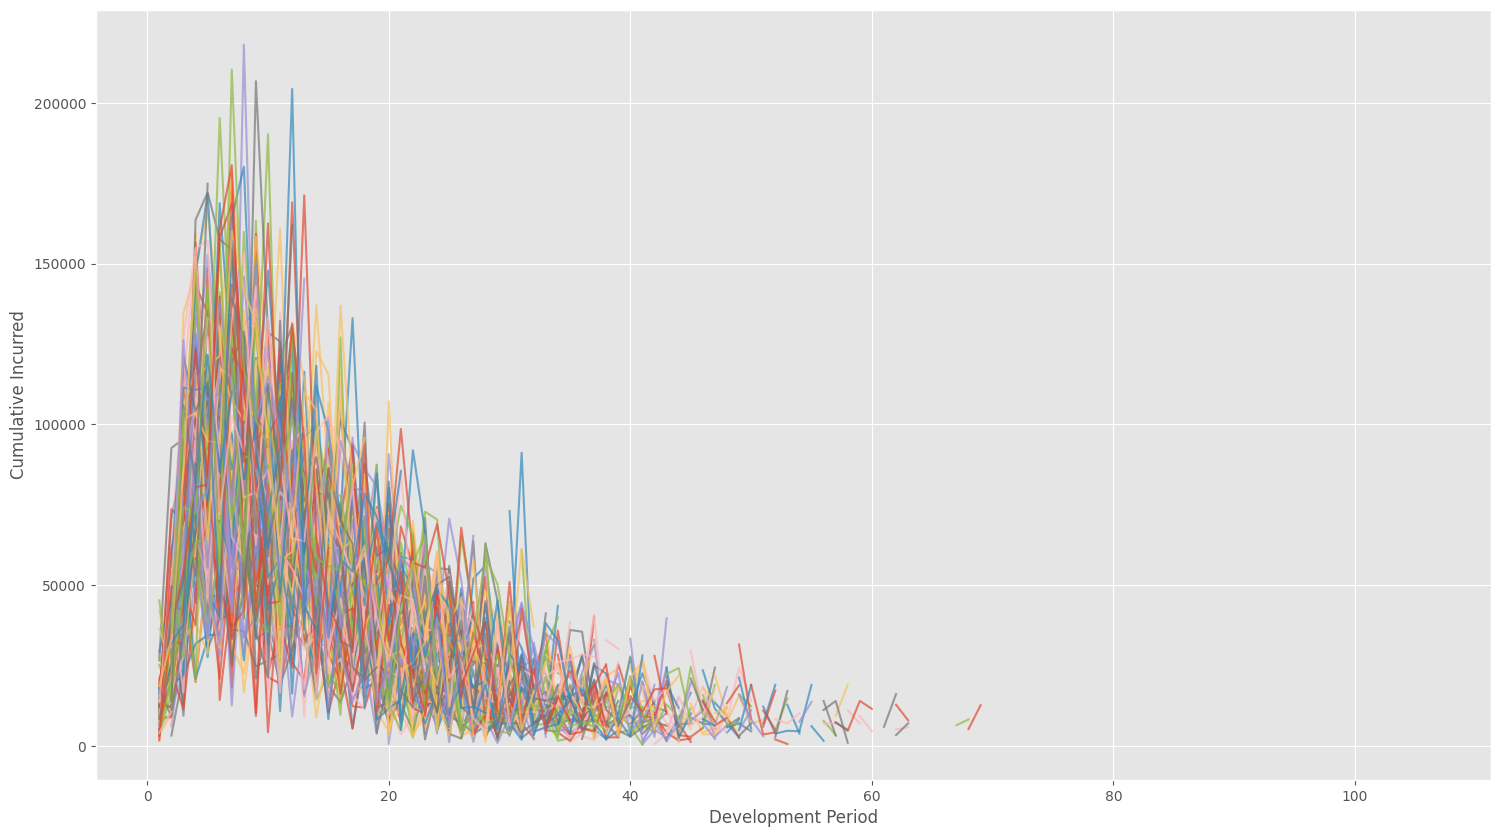

In [9]:
# 그래프 스타일과 크기 설정
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(18, 10))

# 전치(Transpose)된 데이터프레임으로 플롯 생성
df_triangle_PD_Incurred.T.plot(ax=ax, legend=False, alpha=0.7)

# 그래프 제목 및 축 레이블 설정
ax.set_xlabel('Development Period', fontsize=12)
ax.set_ylabel('Cumulative Incurred', fontsize=12)

# 그래프 표시
plt.show()


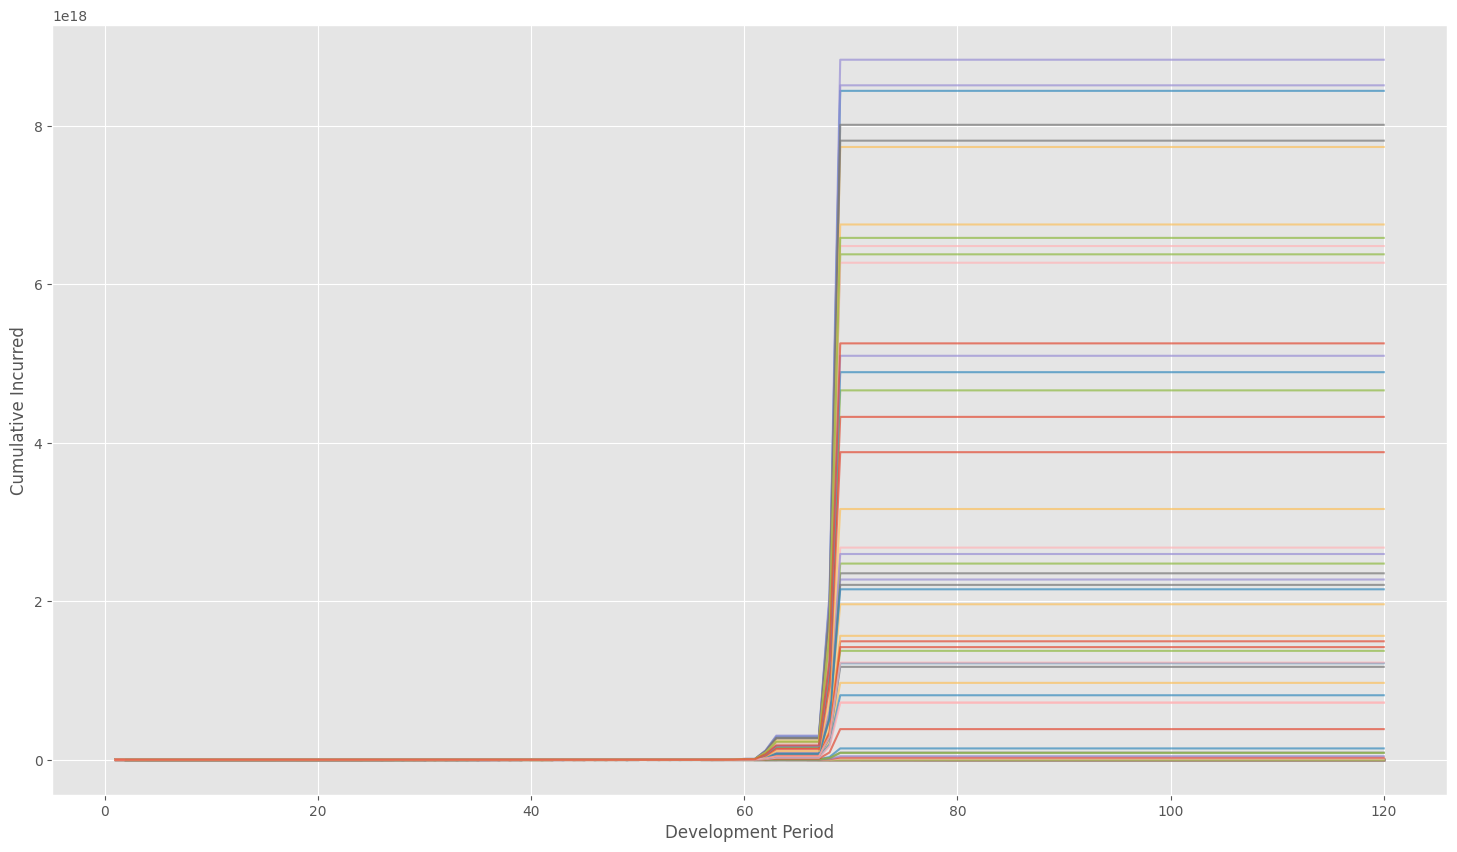

In [10]:
# 그래프 스타일과 크기 설정
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(18, 10))

# 전치(Transpose)된 데이터프레임으로 플롯 생성
df_square_PD_Incurred_CL.T.plot(ax=ax, legend=False, alpha=0.7)

# 그래프 제목 및 축 레이블 설정
ax.set_xlabel('Development Period', fontsize=12)
ax.set_ylabel('Cumulative Incurred', fontsize=12)

# 그래프 표시
plt.show()

In [ ]:
paid_total = prism["Paid"].sum().incr_to_cum()
paid_total_df = paid_total.to_frame(origin_as_datetime=True, keepdims=False)
paid_total_df = paid_total_df.reset_index(drop=True)

paid_total_df


In [ ]:
# paid_total_df: pandas DataFrame (index = origin, columns = development periods)
# Example: paid_total_df.shape -> (120, 120)

# 0) Prepare x-axis: convert columns to numeric dev ages if necessary
try:
    x_vals = np.array([int(c) for c in paid_total_df.columns])
except Exception:
    # fallback: use integer positions 0..(n_dev-1)
    x_vals = np.arange(paid_total_df.shape[1])

# 1) plotting
plt.figure(figsize=(12, 8))

linestyles = ['-', '--', '-.', ':']   # will cycle through these
ls_cycle = cycle(linestyles)

for origin_idx, (origin_label, row) in enumerate(paid_total_df.iterrows()):
    y = row.values.astype(float)                # keep numeric
    mask = ~np.isnan(y)                         # only plot available dev points
    if mask.sum() == 0:
        continue
    xs = x_vals[mask]
    ys = y[mask]
    ls = next(ls_cycle)
    plt.plot(xs, ys, linestyle=ls, linewidth=1.0, alpha=0.6)

# 2) highlight a few (optional): e.g., earliest, median, latest origin
n_rows = paid_total_df.shape[0]
highlights = [0, n_rows // 2, n_rows - 1]
for idx in highlights:
    origin_label = paid_total_df.index[idx]
    y = paid_total_df.iloc[idx].values.astype(float)
    mask = ~np.isnan(y)
    plt.plot(x_vals[mask], y[mask], linewidth=2.2, alpha=0.95, label=f"{origin_label}")

# 3) axes, grid, title
plt.xlabel("Development period")
plt.ylabel("Cumulative Paid")
plt.title("Paid run-off by origin (each row = origin; 120 lines)")
plt.grid(True, linestyle=':', linewidth=0.5)
plt.legend(title="Selected origins", loc='upper left')  # small legend for the highlighted ones
plt.tight_layout()

# 4) optional: log scale if amounts vary hugely
# plt.yscale('log')

# 5) save or show
plt.show()
# plt.savefig("paid_runoff_120_lines.png", dpi=300)


In [ ]:
class UltimateLossSubModelPyTorch(nn.Module):
    """
    A PyTorch implementation of the sub-model from the paper
    "Ultimate Loss Reserve Forecasting Using Bidirectional LSTMs."
    This version includes refinements for modern deep learning frameworks.
    """
    def __init__(self,
                 input_sequence_length: int,
                 output_sequence_length: int,
                 num_companies: int,
                 embedding_dim: int = 10,
                 lstm_units: int = 64,
                 dense_units: int = 64,
                 num_bidirectional_layers: int = 1,
                 num_dense_layers: int = 1,
                 lstm_dropout: float = 0.2):
        """
        Initializes the sub-model architecture.

        Args:
            input_sequence_length (int): Length of the input loss ratio sequence.
            output_sequence_length (int): Number of future loss ratios to predict.
            num_companies (int): Total number of unique companies for embedding.
            embedding_dim (int): Dimension of the company embedding vector.
            lstm_units (int): Number of hidden units in each LSTM direction.
            dense_units (int): Number of units in the hidden dense layers.
            num_bidirectional_layers (int): Number of stacked BiLSTM layers.
            num_dense_layers (int): Number of hidden dense layers.
            lstm_dropout (float): Dropout probability between stacked LSTM layers.
        """
        super().__init__()
        
        # 1. Embedding Layer for Company IDs
        # The +1 is a safety margin for 0-indexed company IDs.
        self.company_embedding = nn.Embedding(
            num_embeddings=num_companies + 1,
            embedding_dim=embedding_dim
        )
        
        # 2. Bidirectional LSTM Layers
        # We use a ModuleList to stack LSTM layers programmatically.
        self.lstm_layers = nn.ModuleList()
        input_size = 1 # Each timestep has 1 feature (the loss ratio)
        for i in range(num_bidirectional_layers):
            self.lstm_layers.append(
                nn.LSTM(
                    input_size=input_size,
                    hidden_size=lstm_units,
                    num_layers=1, # Each element in ModuleList is one layer
                    batch_first=True,
                    bidirectional=True,
                    dropout=lstm_dropout if i < num_bidirectional_layers - 1 else 0
                )
            )
            # The input size for the next LSTM layer is the output of the current one
            input_size = lstm_units * 2 # (forward_units + backward_units)

        # 3. Dense Feed-Forward Network
        # The input features to the dense network come from concatenating
        # the final LSTM state and the company embedding.
        dense_input_features = (lstm_units * 2) + embedding_dim
        
        dense_layers = []
        for i in range(num_dense_layers):
            dense_layers.append(nn.Linear(dense_input_features, dense_units))
            dense_layers.append(nn.SELU()) # SELU activation as per paper
            dense_input_features = dense_units # Input for next layer is output of current
            
        self.dense_network = nn.Sequential(*dense_layers)
        
        # 4. Output Layer
        self.output_layer = nn.Linear(dense_input_features, output_sequence_length)

    def forward(self, sequence_input: torch.Tensor, company_id_input: torch.Tensor) -> torch.Tensor:
        """
        Defines the forward pass of the model.
        
        Args:
            sequence_input (torch.Tensor): Tensor of shape (batch_size, sequence_length).
            company_id_input (torch.Tensor): Tensor of shape (batch_size, 1).

        Returns:
            torch.Tensor: The model's prediction, shape (batch_size, output_sequence_length).
        """
        # --- Embedding Path ---
        # company_id_input shape: (batch_size, 1)
        embedded_ids = self.company_embedding(company_id_input) # -> (batch_size, 1, embedding_dim)
        embedded_ids = embedded_ids.squeeze(1) # -> (batch_size, embedding_dim)

        # --- Sequence Path ---
        # sequence_input shape: (batch_size, sequence_length)
        # LSTM expects a 3D tensor: (batch, seq, features)
        x = sequence_input.unsqueeze(-1) # -> (batch_size, sequence_length, 1)
        
        for lstm_layer in self.lstm_layers:
            x, _ = lstm_layer(x) # x shape: (batch_size, seq_len, 2 * lstm_units)
        
        # We take the last hidden state from the sequence output
        # x[:, -1, :] selects the output of the last time step for all batches
        lstm_output = x[:, -1, :] # -> (batch_size, 2 * lstm_units)
        
        # --- Fusion and Final Prediction ---
        # Concatenate sequence features with company-specific features
        combined_features = torch.cat([lstm_output, embedded_ids], dim=1)
        
        # Pass through the dense network
        dense_output = self.dense_network(combined_features)
        
        # Final output projection
        output = self.output_layer(dense_output)
        
        return output
    

In [ ]:
ay_count, dev_count = 120, 120

paid_total_df.index.name = 'AccidentMonth'
paid_total_df.columns.name = 'DevelopmentMonth'

# 1. Calculate Age-to-Age Factors (LDFs)
# LDF = Cumulative Loss at Month(t) / Cumulative Loss at Month(t-1)
ldf_df = paid_total_df.div(paid_total_df.shift(1, axis='columns'))

# 2. Handle NaNs and Infs created by division
# - The first development month column will be all NaN.
# - Divisions by zero can create infs.
# We replace these. A common practice is to fill with 1.0 (no development).
ldf_df.replace([np.inf, -np.inf], np.nan, inplace=True)
ldf_df.fillna(1.0, inplace=True)

# The first column is meaningless for LDFs, so we drop it.
ldf_df = ldf_df.drop(columns=ldf_df.columns[0])

ldf_df


In [ ]:
# --- Configuration for sequencing ---
INPUT_SEQ_LEN = 12  # Use 12 months of LDFs to predict the next...
OUTPUT_SEQ_LEN = 6  # ...6 months of LDFs. Adjust as needed.

X_seq, X_id, y_target = [], [], []

# Iterate over each accident year (each row in the LDF table)
for ay_idx, ldf_series in ldf_df.iterrows():
    # Get the valid, known LDFs for this accident year
    known_ldfs = ldf_series.dropna().values
    
    # Slide a window to create training samples
    for i in range(len(known_ldfs) - INPUT_SEQ_LEN - OUTPUT_SEQ_LEN + 1):
        input_start = i
        input_end = i + INPUT_SEQ_LEN
        output_end = input_end + OUTPUT_SEQ_LEN
        
        # Define the input sequence, company ID, and target
        seq_x = known_ldfs[input_start:input_end]
        seq_y = known_ldfs[input_end:output_end]
        
        X_seq.append(seq_x)
        X_id.append([ay_idx]) # The ID is the accident year index
        y_target.append(seq_y)

# Convert to PyTorch Tensors
X_seq_tensor = torch.tensor(np.array(X_seq), dtype=torch.float32)
X_id_tensor = torch.tensor(np.array(X_id), dtype=torch.long)
y_target_tensor = torch.tensor(np.array(y_target), dtype=torch.float32)

print(f"Number of training samples: {len(X_seq)}")
print(f"X_seq shape: {X_seq_tensor.shape}")
print(f"X_id shape: {X_id_tensor.shape}")
print(f"y_target shape: {y_target_tensor.shape}")


In [ ]:
# --- Model and Training Setup ---
NUM_ACCIDENT_YEARS = len(ldf_df)
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
EPOCHS = 100
BATCH_SIZE = 64

# 1. Instantiate the Model
model = UltimateLossSubModelPyTorch(
    input_sequence_length=INPUT_SEQ_LEN,
    output_sequence_length=OUTPUT_SEQ_LEN,
    num_companies=NUM_ACCIDENT_YEARS, # Treat each AY as a company
    embedding_dim=15,
    lstm_units=128,
    dense_units=128,
    num_bidirectional_layers=2,
    num_dense_layers=1,
    lstm_dropout=0.2
)

# 2. Define Loss Function and Optimizer
# Using MSELoss is more robust than MAPE if LDFs can be close to 1.0
loss_fn = nn.MSELoss() 
# AdamW is a modern optimizer that handles weight decay (L2 regularization) correctly
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# 3. Create a DataLoader
dataset = TensorDataset(X_seq_tensor, X_id_tensor, y_target_tensor)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [ ]:

# --- Training Loop with Time Estimation ---
print("\n--- Starting Model Training ---")

# 1. Start a timer before the loop begins
training_start_time = time.time()

model.train()
# 2. Wrap the `range(EPOCHS)` iterable with tqdm()
#    - desc: A description for the progress bar.
for epoch in tqdm(range(EPOCHS), desc="Training Progress"):
    total_loss = 0
    # Optional: You can also wrap the inner loop for per-epoch progress
    # for seq_batch, id_batch, target_batch in tqdm(dataloader, desc=f"Epoch {epoch+1}", leave=False):
    for seq_batch, id_batch, target_batch in dataloader:
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(seq_batch, id_batch)
        
        # Calculate loss
        loss = loss_fn(predictions, target_batch)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    avg_loss = total_loss / len(dataloader)
    
    # You can still print your custom logs if needed. TQDM handles this cleanly.
    if (epoch + 1) % 10 == 0:
        print(f"\nEpoch {epoch+1}/{EPOCHS}, Avg Loss: {avg_loss:.6f}")

# 3. Calculate and print the total time taken after the loop
total_training_time = time.time() - training_start_time
print(f"\n--- Training Finished ---")
print(f"Total Elapsed Time: {total_training_time:.2f} seconds")


In [ ]:
print("\n--- Starting Auto-Regressive LDF Forecasting ---")
model.eval()

# Store the full LDF series for each accident year
predicted_ldf_tails = {}
final_dev_month = paid_total_df.shape[1] # e.g., 120

for ay_idx, ldf_series in ldf_df.iterrows():
    known_ldfs = ldf_series.dropna().values
    num_known_ldfs = len(known_ldfs)
    
    # If AY is fully developed, no prediction is needed.
    if num_known_ldfs >= final_dev_month -1:
        predicted_ldf_tails[ay_idx] = known_ldfs
        continue
        
    # Start with the last known LDFs as the initial input
    current_input_ldfs = list(known_ldfs)
    
    # Get the integer ID for the current accident year
    current_ay_id_tensor = torch.tensor([ay_idx], dtype=torch.long)
    
    with torch.no_grad():
        # Loop until we have enough LDFs to reach the final development month
        while len(current_input_ldfs) < final_dev_month - 1:
            # Prepare the input tensor from the most recent LDFs
            input_seq = torch.tensor(current_input_ldfs[-INPUT_SEQ_LEN:], dtype=torch.float32).unsqueeze(0)
            
            # Make a prediction for the next chunk of LDFs
            prediction = model(input_seq, current_ay_id_tensor)
            
            # Append the new predictions to our list
            newly_predicted_ldfs = prediction.squeeze().tolist()
            current_input_ldfs.extend(newly_predicted_ldfs)

    # Store the completed LDF series (original + predicted)
    predicted_ldf_tails[ay_idx] = current_input_ldfs

print("Completed forecasting all LDF tails.")

In [ ]:
print("\n--- Constructing Full Cumulative Loss Square Matrix ---")

# Start with a copy of the original triangle
full_cumulative_df = paid_total_df.copy()

# Iterate over each accident year (row)
for ay_idx in full_cumulative_df.index:
    # Get the completed LDF series for this AY
    full_ldf_series = predicted_ldf_tails[ay_idx]
    
    # Find the last valid (non-NaN) column index in the original data
    last_known_paid_idx = full_cumulative_df.loc[ay_idx].last_valid_index()
    
    if last_known_paid_idx is None: # Handle empty rows if any
        continue
        
    start_col_idx = full_cumulative_df.columns.get_loc(last_known_paid_idx)

    # Iteratively calculate the future cumulative values
    # We loop from the column AFTER the last known payment to the end
    for j in range(start_col_idx + 1, final_dev_month):
        # Previous cumulative paid value
        prev_cumulative = full_cumulative_df.iloc[ay_idx, j - 1]
        
        # Corresponding LDF to project to the next month
        # The LDF index is j-1 because ldf_df has one less column than paid_df
        ldf = full_ldf_series[j - 1] 
        
        # Projection: C[t] = C[t-1] * LDF[t-1 -> t]
        full_cumulative_df.iloc[ay_idx, j] = prev_cumulative * ldf

print("Full runoff square matrix has been generated.")

In [ ]:
# The reserve can now be calculated from this completed square
latest_paid = paid_total_df.apply(lambda row: row.dropna().iloc[-1], axis=1)
ultimate_loss = full_cumulative_df.iloc[:, -1] # Last column is the ultimate loss

results_df = pd.DataFrame({
    'LatestCumulativePaid': latest_paid,
    'CalculatedUltimateLoss': ultimate_loss
})
results_df['ProjectedReserve'] = results_df['CalculatedUltimateLoss'] - results_df['LatestCumulativePaid']
total_reserve = results_df['ProjectedReserve'].sum()

print(f"\n\n💰 **Total Projected Loss Reserve (from square): ${total_reserve:,.2f}**")
full_cumulative_df


In [ ]:

try:
    x_vals = np.array([int(c) for c in full_cumulative_df.columns])
except Exception:
    # fallback: use integer positions 0..(n_dev-1)
    x_vals = np.arange(full_cumulative_df.shape[1])

# 1) plotting
plt.figure(figsize=(12, 8))

linestyles = ['-', '--', '-.', ':']   # will cycle through these
ls_cycle = cycle(linestyles)

for origin_idx, (origin_label, row) in enumerate(full_cumulative_df.iterrows()):
    y = row.values.astype(float)                # keep numeric
    mask = ~np.isnan(y)                         # only plot available dev points
    if mask.sum() == 0:
        continue
    xs = x_vals[mask]
    ys = y[mask]
    ls = next(ls_cycle)
    plt.plot(xs, ys, linestyle=ls, linewidth=1.0, alpha=0.6)

# 2) highlight a few (optional): e.g., earliest, median, latest origin
n_rows = full_cumulative_df.shape[0]
highlights = [0, n_rows // 2, n_rows - 1]
for idx in highlights:
    origin_label = full_cumulative_df.index[idx]
    y = full_cumulative_df.iloc[idx].values.astype(float)
    mask = ~np.isnan(y)
    plt.plot(x_vals[mask], y[mask], linewidth=2.2, alpha=0.95, label=f"{origin_label}")

# 3) axes, grid, title
plt.xlabel("Development period")
plt.ylabel("Cumulative Paid")
plt.title("Paid run-off by origin (each row = origin; 120 lines)")
plt.grid(True, linestyle=':', linewidth=0.5)
plt.legend(title="Selected origins", loc='upper left')  # small legend for the highlighted ones
plt.tight_layout()

# 4) optional: log scale if amounts vary hugely
# plt.yscale('log')

# 5) save or show
plt.show()
# plt.savefig("paid_runoff_120_lines.png", dpi=300)
